## Data loading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import umap
from mlxtend.preprocessing import TransactionEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import scipy
from sklearn import metrics
import timeit

ModuleNotFoundError: No module named 'umap'

In [ ]:
data = pd.read_csv('C:/Users/Cem/Documents/GitHub/Frequent-Pattern-Mining-and-Clustering/dataset/Shill Bidding Dataset.csv')
data.info()

In [13]:
data.head()

,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,1,732,_***i,0.200000,0.400000,0.0,0.000028,0.0,0.993593,0.000028,0.666667,5,0
1,2,732,g***r,0.024390,0.200000,0.0,0.013123,0.0,0.993593,0.013123,0.944444,5,0
2,3,732,t***p,0.142857,0.200000,0.0,0.003042,0.0,0.993593,0.003042,1.000000,5,0
3,4,732,7***n,0.100000,0.200000,0.0,0.097477,0.0,0.993593,0.097477,1.000000,5,0
4,5,900,z***z,0.051282,0.222222,0.0,0.001318,0.0,0.000000,0.001242,0.500000,7,0


In [14]:
# There is no null variable in the data, no need to remove Nan. 
# All the data are numerical, and the three variables about ID can be dropped.
data1 = data[['Bidder_Tendency',
       'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding',
       'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding',
       'Winning_Ratio', 'Auction_Duration', 'Class']]
data1.head()

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,0.200000,0.400000,0.0,0.000028,0.0,0.993593,0.000028,0.666667,5,0
1,0.024390,0.200000,0.0,0.013123,0.0,0.993593,0.013123,0.944444,5,0
2,0.142857,0.200000,0.0,0.003042,0.0,0.993593,0.003042,1.000000,5,0
3,0.100000,0.200000,0.0,0.097477,0.0,0.993593,0.097477,1.000000,5,0
4,0.051282,0.222222,0.0,0.001318,0.0,0.000000,0.001242,0.500000,7,0


In [1]:
# Histogram plotting
plt.figure(figsize=(15,15))
i = 0

col_list = ['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio', 'Auction_Duration', 'Class']
for col in col_list:
  i = i + 1
  plt.subplot(4,3,i)
  sns.histplot(data=data[col], legend=True)

plt.show()

NameError: name 'plt' is not defined

<Figure size 1800x1440 with 0 Axes>

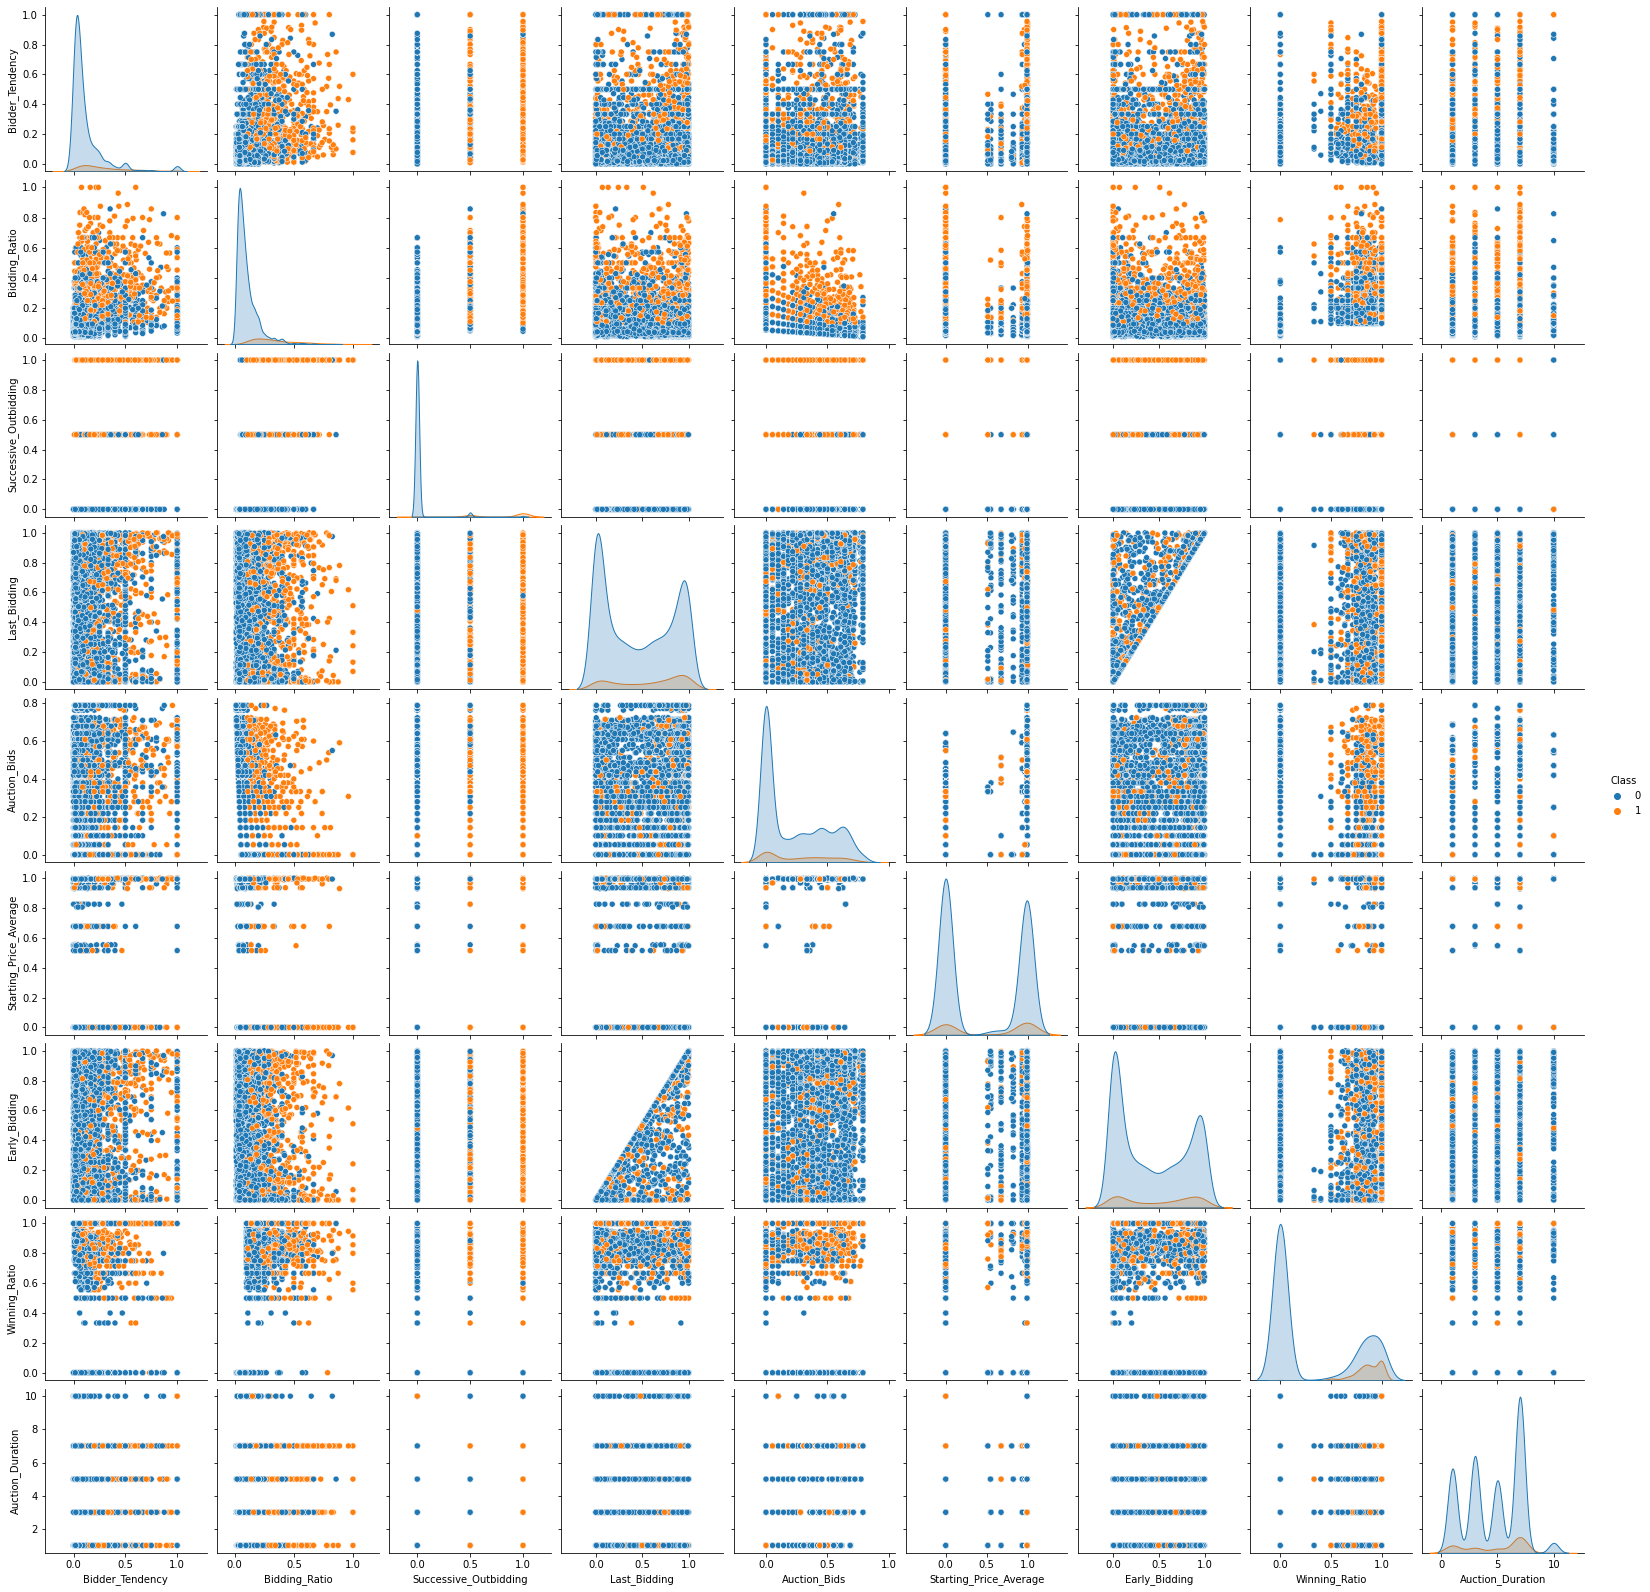

In [10]:
# Pair plotting
plt.figure(figsize=(25,20))
sns.pairplot(data1, hue='Class')
plt.show()

**Observation:** No pair of two variables can separate the two class.

But Bidder_Tendency, Bidding_Ration and Successive_Outbidding show that the smaller values of the three features represent more normal bidders.

Another observation is that data might be able to be divided into groups by Auction_Duration without affecting the distribution.

Statistical analysis to confirm if there is a significant difference in each features among the Auction_Durations.

Since the features are all not normally distributed, Kruskal-Wallis is used to test.

In [16]:
data1_col_dur_list = ['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']

for col in data1_col_dur_list:
  print(col)
  dur_list = [1,3,5,7,10]

  for i in range(0,4):
    dur_list1 = dur_list[i+1:]

    for j in dur_list1:
      print('Duration ',dur_list[i],'~ Duration ',j, ': pvalue=', stats.kruskal(data1[data1['Auction_Duration']==dur_list[i]][col], data1[data1['Auction_Duration']==j][col])[1])
    
  print('-------------------------------------------------------------------------------------------------------------')


Bidder_Tendency
Duration  1 ~ Duration  3 : pvalue= 0.6966023397831832
Duration  1 ~ Duration  5 : pvalue= 0.4793660843340304
Duration  1 ~ Duration  7 : pvalue= 0.9344002917017548
Duration  1 ~ Duration  10 : pvalue= 0.04517460218654448
Duration  3 ~ Duration  5 : pvalue= 0.7271581404175813
Duration  3 ~ Duration  7 : pvalue= 0.729742480022295
Duration  3 ~ Duration  10 : pvalue= 0.07443894016187297
Duration  5 ~ Duration  7 : pvalue= 0.48010036934088474
Duration  5 ~ Duration  10 : pvalue= 0.1183085861883225
Duration  7 ~ Duration  10 : pvalue= 0.05026859712280161
-------------------------------------------------------------------------------------------------------------
Bidding_Ratio
Duration  1 ~ Duration  3 : pvalue= 0.8239099593171679
Duration  1 ~ Duration  5 : pvalue= 0.1283495308898885
Duration  1 ~ Duration  7 : pvalue= 0.008958584749331476
Duration  1 ~ Duration  10 : pvalue= 0.00017401995356576726
Duration  3 ~ Duration  5 : pvalue= 0.07911828899622692
Duration  3 ~ Durati

In [17]:
data1['Auction_Duration'].value_counts()

7     2427
3     1408
1     1289
5     1060
10     137
Name: Auction_Duration, dtype: int64

## Algorithm evaluation & Data preparation

In [19]:
# Many features are not significantly different between each auction duration pairs. 
# However, Auction_Bids and Starting_Price_Average are mostly significantly different between auction duration pairs.
# So, it should be safe to consider the shill bidder separately according to the action durations.
X1 = data1[data1['Auction_Duration']==1][['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']]
y1 = data1[data1['Auction_Duration']==1]['Class']
X3 = data1[data1['Auction_Duration']==3][['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']]
y3 = data1[data1['Auction_Duration']==3]['Class']
X5 = data1[data1['Auction_Duration']==5][['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']]
y5 = data1[data1['Auction_Duration']==5]['Class']
X7 = data1[data1['Auction_Duration']==7][['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']]
y7 = data1[data1['Auction_Duration']==7]['Class']
X10 = data1[data1['Auction_Duration']==10][['Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding', 'Winning_Ratio']]
y10 = data1[data1['Auction_Duration']==10]['Class']

In [20]:
te = TransactionEncoder()
te_ary = te.fit(data1).transform(data1)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,A,B,C,D,E,L,O,P,R,S,T,W,_,a,b,c,d,e,g,i,l,n,o,r,s,t,u,v,y
0,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,True,True,True,False,True,False,True,False,True,False,False,False,False,True
1,False,True,False,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,True,True,False,True,True,False,False,True,False,False,False
2,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True,True,True,True,True,True,False,True,False,False,True,True,True,True,False
3,False,True,False,False,False,True,False,False,False,False,False,False,True,True,False,False,True,False,True,True,False,True,False,False,True,True,False,False,False
4,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,True,False,True,True,False,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6316,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6317,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6318,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6319,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


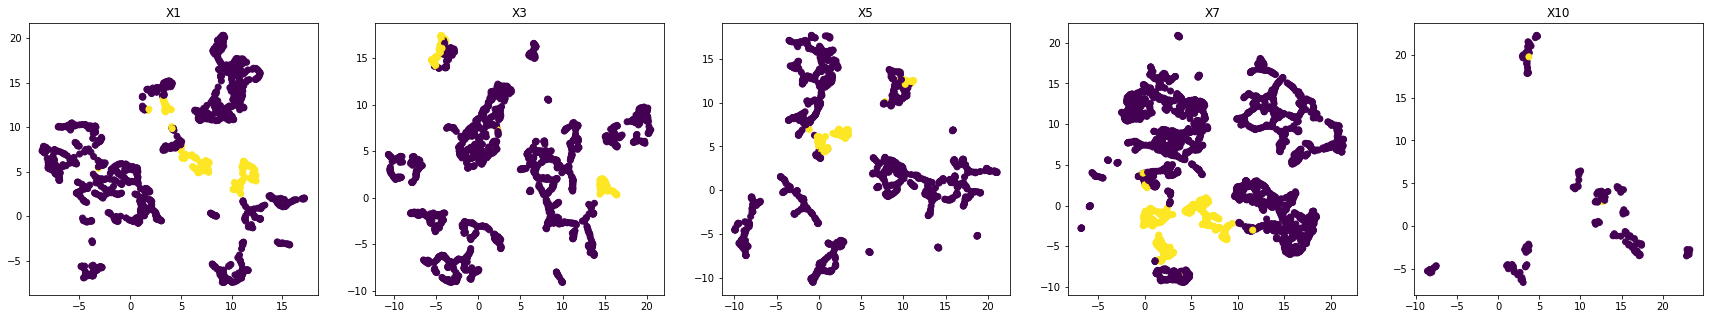

In [21]:
# Dimension reduction for QC plot
plt.figure(figsize=(30,5))
 
X1_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=42).fit_transform(X1)
plt.subplot(1,5,1)
plt.scatter(X1_umap[:,0], X1_umap[:,1], c=y1)
plt.title('X1')

X3_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=42).fit_transform(X3)
plt.subplot(1,5,2)
plt.scatter(X3_umap[:,0], X3_umap[:,1], c=y3)
plt.title('X3')

X5_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=42).fit_transform(X5)
plt.subplot(1,5,3)
plt.scatter(X5_umap[:,0], X5_umap[:,1], c=y5)
plt.title('X5')

X7_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=42).fit_transform(X7)
plt.subplot(1,5,4)
plt.scatter(X7_umap[:,0], X7_umap[:,1], c=y7)
plt.title('X7')

X10_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=42).fit_transform(X10)
plt.subplot(1,5,5)
plt.scatter(X10_umap[:,0], X10_umap[:,1], c=y10)
plt.title('X10')

plt.show()

[0.40872983 0.25755841]
[0.40568432 0.24013012]
[0.44401237 0.23478025]
[0.43191601 0.24643219]
[0.45369122 0.27598034]


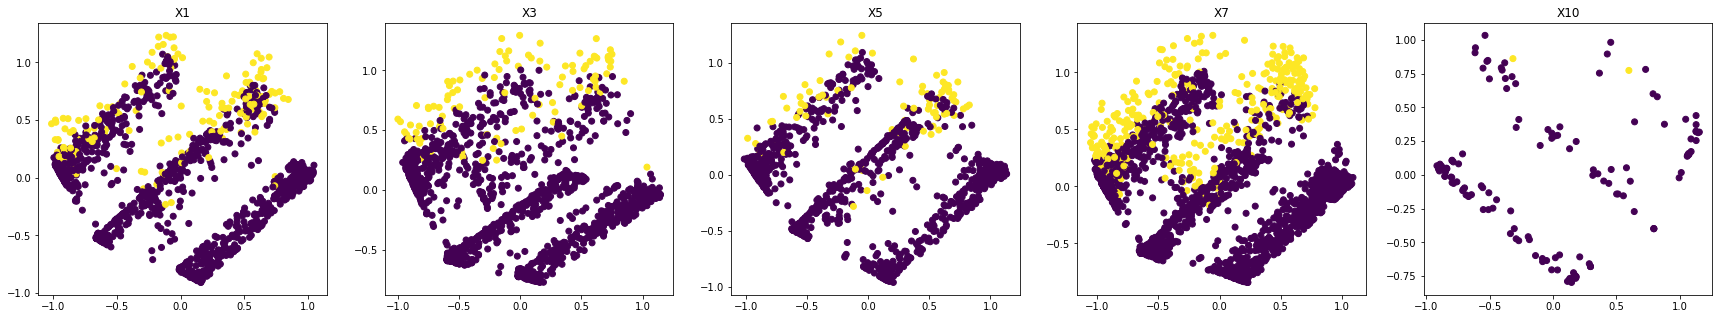

In [22]:
plt.figure(figsize=(30,5))
 
X1_pca = PCA(n_components=2, random_state=42).fit_transform(X1)
print(PCA(n_components=2).fit(X1).explained_variance_ratio_)
plt.subplot(1,5,1)
plt.scatter(X1_pca[:,0], X1_pca[:,1], c=y1)
plt.title('X1')

X3_pca = PCA(n_components=2, random_state=42).fit_transform(X3)
print(PCA(n_components=2).fit(X3).explained_variance_ratio_)
plt.subplot(1,5,2)
plt.scatter(X3_pca[:,0], X3_pca[:,1], c=y3)
plt.title('X3')

X5_pca = PCA(n_components=2, random_state=42).fit_transform(X5)
print(PCA(n_components=2).fit(X5).explained_variance_ratio_)
plt.subplot(1,5,3)
plt.scatter(X5_pca[:,0], X5_pca[:,1], c=y5)
plt.title('X5')

X7_pca = PCA(n_components=2, random_state=42).fit_transform(X7)
print(PCA(n_components=2).fit(X7).explained_variance_ratio_)
plt.subplot(1,5,4)
plt.scatter(X7_pca[:,0], X7_pca[:,1], c=y7)
plt.title('X7')

X10_pca = PCA(n_components=2, random_state=42).fit_transform(X10)
print(PCA(n_components=2).fit(X10).explained_variance_ratio_)
plt.subplot(1,5,5)
plt.scatter(X10_pca[:,0], X10_pca[:,1], c=y10)
plt.title('X10')

plt.show()

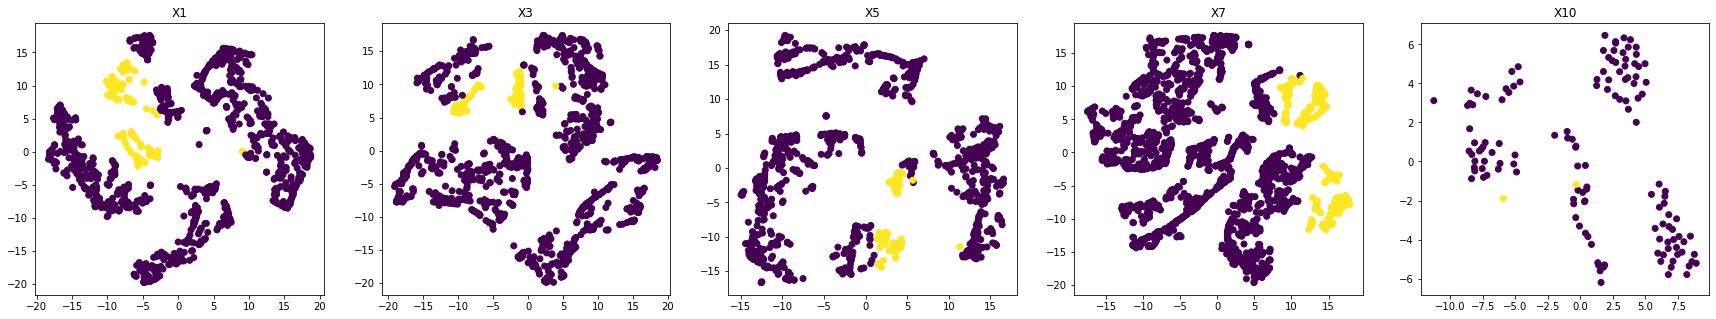

In [23]:
plt.figure(figsize=(30,5))
 
X1_tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42).fit_transform(X1)
plt.subplot(1,5,1)
plt.scatter(X1_tsne[:,0], X1_tsne[:,1], c=y1)
plt.title('X1')

X3_tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42).fit_transform(X3)
plt.subplot(1,5,2)
plt.scatter(X3_tsne[:,0], X3_tsne[:,1], c=y3)
plt.title('X3')

X5_tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42).fit_transform(X5)
plt.subplot(1,5,3)
plt.scatter(X5_tsne[:,0], X5_tsne[:,1], c=y5)
plt.title('X5')

X7_tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42).fit_transform(X7)
plt.subplot(1,5,4)
plt.scatter(X7_tsne[:,0], X7_tsne[:,1], c=y7)
plt.title('X7')

X10_tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42).fit_transform(X10)
plt.subplot(1,5,5)
plt.scatter(X10_tsne[:,0], X10_tsne[:,1], c=y10)
plt.title('X10')

plt.show()

**Observation:** 
* The first two components of PCA presents 65~73% variables, and do not separate the two classes as well as umap and tsne methods. 
* tsne shows the most split clusters to separate the classes. 
* And one more thing is interesting to point out that the data looks not to contain only two clusters, although the normal bidders and shill bidders are two classes. So, there should be more than two clusters can be labeled as normal bidders and the others can be labeled as shill bidders.

## KMeans

Max silhouette coeficient for X1 is 0.4719669924586248 for 10 cluster
Max silhouette coeficient for X3 is 0.4572223569773677 for 10 cluster
Max silhouette coeficient for X5 is 0.5046749101132672 for 10 cluster
Max silhouette coeficient for X7 is 0.4677716313148853 for 10 cluster
Max silhouette coeficient for X10 is 0.5292520401728247 for 8 cluster


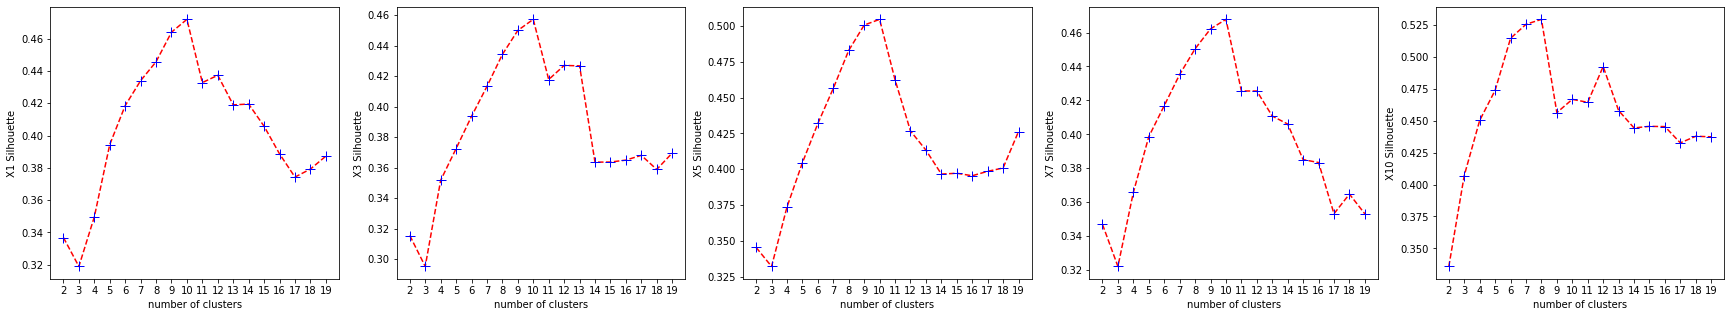

Runtime of KMeans algorithm:  18.65258598100081


In [27]:
### KMeans parameter scan
start = timeit.default_timer()
plt.figure(figsize=(30,5))

X_list = {'X1':X1, 'X3':X3, 'X5':X5, 'X7':X7, 'X10':X10}
i=0

for x_str, x in X_list.items():
  silhouette_list = []
  i=i+1
  for k in range(2,20):
    kmeans_fit = KMeans(n_clusters=k, max_iter=300, random_state=42).fit(x)
    y_pred = kmeans_fit.predict(x)
    silhouette_list.append(metrics.silhouette_score(x, y_pred, metric='euclidean'))
  plt.subplot(1,5,i)
  plt.plot(range(2,20),silhouette_list, marker = '+',color = 'red' , ls = '--', markeredgecolor = 'blue', markersize = '10')
  plt.ylabel(x_str+' Silhouette')
  plt.xlabel('number of clusters')
  plt.xticks(np.arange(2,20,1))
  max_s = max(silhouette_list)
  max_k = silhouette_list.index(max_s)+2
  print('Max silhouette coeficient for {} is {} for {} cluster'.format(x_str, max_s, max_k))

plt.show()
stop = timeit.default_timer()
print('Runtime of KMeans algorithm: ', stop - start)

## AGNES

Method: ward: X1: n_neighbors: 10, Max Silhouette coefficient: 0.44999615523186515
Method: ward: X3: n_neighbors: 11, Max Silhouette coefficient: 0.4407952486452096
Method: ward: X5: n_neighbors: 11, Max Silhouette coefficient: 0.4816596725564041
Method: ward: X7: n_neighbors: 9, Max Silhouette coefficient: 0.38785472788195535
Method: ward: X10: n_neighbors: 10, Max Silhouette coefficient: 0.5365236390855176
Method: complete: X1: n_neighbors: 12, Max Silhouette coefficient: 0.3543817347414326
Method: complete: X3: n_neighbors: 2, Max Silhouette coefficient: 0.3010061763956822
Method: complete: X5: n_neighbors: 11, Max Silhouette coefficient: 0.4034030940534714
Method: complete: X7: n_neighbors: 16, Max Silhouette coefficient: 0.32773732934452754
Method: complete: X10: n_neighbors: 10, Max Silhouette coefficient: 0.527280283182995
Method: average: X1: n_neighbors: 18, Max Silhouette coefficient: 0.33630235268084985
Method: average: X3: n_neighbors: 16, Max Silhouette coefficient: 0.2898

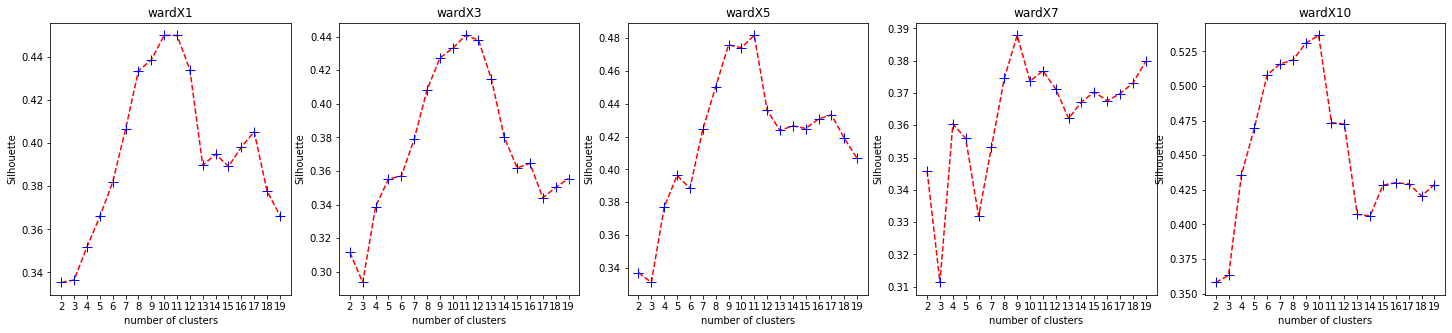

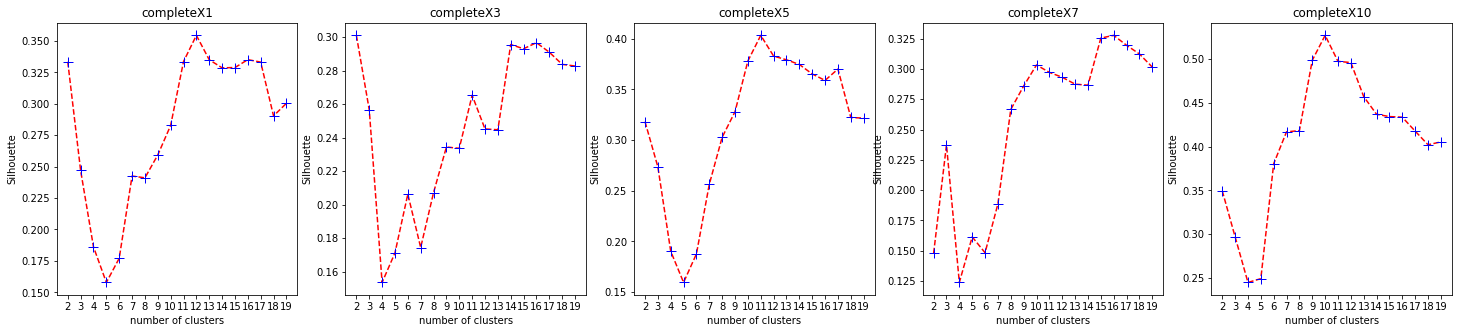

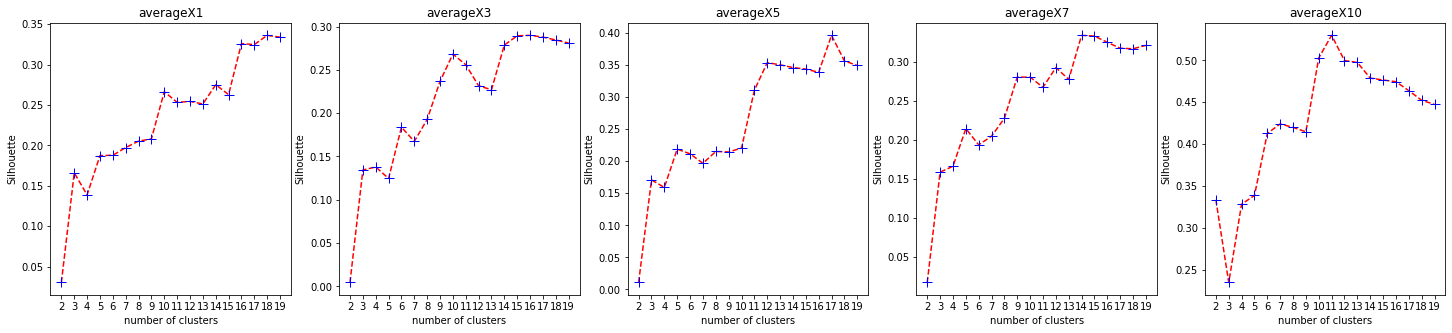

Runtime of AGNES algorithm:  36.32866493399979


In [28]:
### Agglomerative clustering parameter scan
start = timeit.default_timer()
method_list = ['ward', 'complete', 'average']

for method in method_list:
  sim = 'cosine'
  if(method=='ward'):
    sim = 'euclidean'
  i = 0
  plt.figure(figsize=(25,5))

  for x_str, x in X_list.items():
    silhouette_list = []

    for k in range(2,20):
      pred = AgglomerativeClustering(n_clusters=k, affinity=sim, linkage=method).fit_predict(x)
      silhouette_list.append(metrics.silhouette_score(x, pred, metric='euclidean'))
    max_s = max(silhouette_list)
    max_k = silhouette_list.index(max_s)+2
    print('Method: {}: {}: n_neighbors: {}, Max Silhouette coefficient: {}'.format(method, x_str, max_k, max_s))

    i = i + 1
    plt.subplot(1,5,i)
    plt.plot(range(2,20), silhouette_list, marker = '+',color = 'red' , ls = '--', markeredgecolor = 'blue', markersize = '10')
    plt.title(method+x_str)
    plt.ylabel('Silhouette')
    plt.xlabel('number of clusters')
    plt.xticks(np.arange(2,20,1))

plt.show()
stop = timeit.default_timer()
print('Runtime of AGNES algorithm: ', stop - start)

DBSCAN

In [29]:
### DBSCAN

# DBSCAN has overall low Silhouette coeffcients, and results in 1 cluster for X1 and X10.
start = timeit.default_timer()
eps_list = [0.2, 0.5, 0.7]
for eps_n in eps_list:
  silhouette_list = []

  for sp_n in range(1, 20):
    pred = DBSCAN(eps=eps_n, min_samples=sp_n).fit_predict(X3)
    silhouette_list.append(metrics.silhouette_score(X3, pred, metric='euclidean'))
  max_s = max(silhouette_list)
  print('eps: {},  min_sample: {},  {}, Max Silhouette coefficient: {}'.format(eps_n, sp_n, 'X3', max_s))

  for sp_n in range(1, 20):
    pred = DBSCAN(eps=eps_n, min_samples=sp_n).fit_predict(X5)
    silhouette_list.append(metrics.silhouette_score(X5, pred, metric='euclidean'))
  max_s = max(silhouette_list)
  print('eps: {},  min_sample: {},  {}, Max Silhouette coefficient: {}'.format(eps_n, sp_n, 'X5', max_s))

  for sp_n in range(1, 20):
    pred = DBSCAN(eps=eps_n, min_samples=sp_n).fit_predict(X7)
    silhouette_list.append(metrics.silhouette_score(X7, pred, metric='euclidean'))
  max_s = max(silhouette_list)
  print('eps: {},  min_sample: {},  {}, Max Silhouette coefficient: {}'.format(eps_n, sp_n, 'X7', max_s))

stop = timeit.default_timer()
print('Runtime of DBScan algorithm: ', stop - start)

eps: 0.2,  min_sample: 19,  X3, Max Silhouette coefficient: 0.1888354663410392
eps: 0.2,  min_sample: 19,  X5, Max Silhouette coefficient: 0.27091413495528915
eps: 0.2,  min_sample: 19,  X7, Max Silhouette coefficient: 0.2771798287747163
eps: 0.5,  min_sample: 19,  X3, Max Silhouette coefficient: 0.2073361904325334
eps: 0.5,  min_sample: 19,  X5, Max Silhouette coefficient: 0.2944246244617833
eps: 0.5,  min_sample: 19,  X7, Max Silhouette coefficient: 0.2944246244617833
eps: 0.7,  min_sample: 19,  X3, Max Silhouette coefficient: 0.25810890649881946
eps: 0.7,  min_sample: 19,  X5, Max Silhouette coefficient: 0.25810890649881946
eps: 0.7,  min_sample: 19,  X7, Max Silhouette coefficient: 0.25810890649881946
Runtime of DBScan algorithm:  27.4135942110006


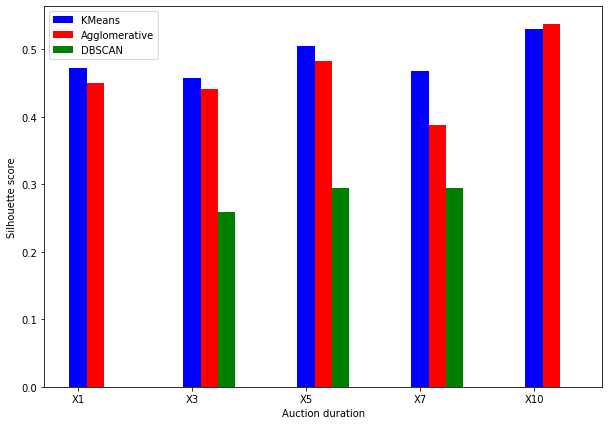

In [ ]:
### Silhouette score examination

sil_df = pd.DataFrame(index=['X1', 'X3', 'X5', 'X7', 'X10'], columns=['KMeans', 'Agglomerative', 'DBSCAN'])
sil_df['KMeans'] = [0.4719669924586248,0.4572223569773677,0.5046749101132672,0.4677716313148853,0.5292520401728247]
sil_df['Agglomerative'] = [0.44999615523186515,0.4407952486452096,0.4816596725564041,0.38785472788195535,0.5365236390855176]
sil_df['DBSCAN'] = [0,0.25810890649881946,0.2944246244617833,0.2944246244617833,0]

plt.figure(figsize=(10,7))
X_ind = np.arange(sil_df.shape[0])
index_list = ['X1', 'X3', 'X5', 'X7', 'X10']
plt.bar(X_ind, sil_df['KMeans'], color='b', width=0.15)
plt.bar(X_ind+0.15, sil_df['Agglomerative'], color='r', width=0.15)
plt.bar(X_ind+0.3, sil_df['DBSCAN'], color='g', width=0.15)
plt.xticks(X_ind, index_list)
plt.xlabel('Auction duration')
plt.ylabel('Silhouette score')
plt.legend(labels=['KMeans', 'Agglomerative', 'DBSCAN'])
plt.show()

**Observation:** KMeans overall shows the best Silhouette scores, KMeans is used for clustering.

##Clustering using KMeans

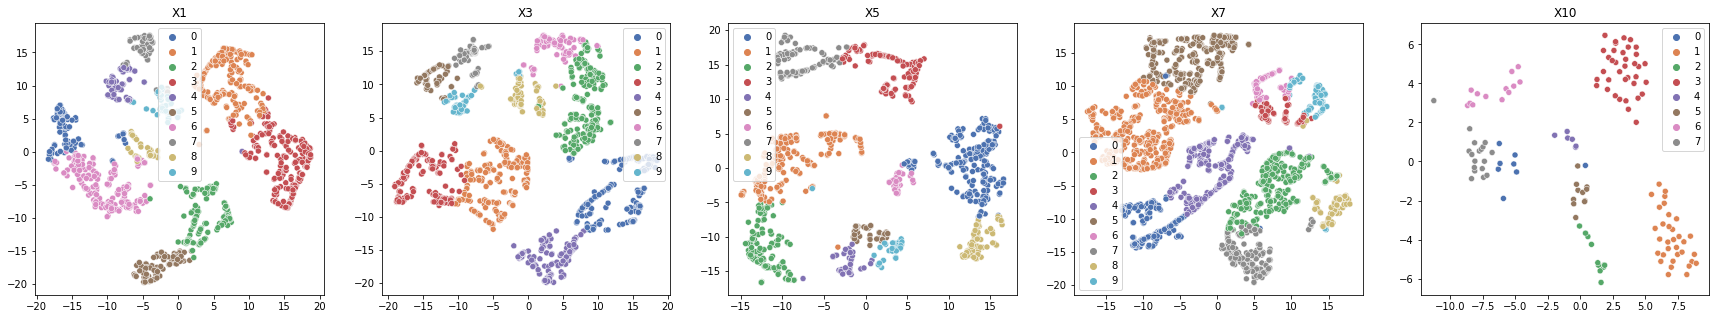

In [ ]:
###KMeans Prediction

plt.figure(figsize=(30,5))

plt.subplot(1,5,1)
y1_kmeans = KMeans(n_clusters=10, random_state=42).fit_predict(X1)
sns.scatterplot(x=X1_tsne[:,0], y=X1_tsne[:,1], hue=y1_kmeans, palette="deep")
plt.title('X1')

plt.subplot(1,5,2)
y3_kmeans = KMeans(n_clusters=10, random_state=42).fit_predict(X3)
sns.scatterplot(x=X3_tsne[:,0], y=X3_tsne[:,1], hue=y3_kmeans, palette="deep")
plt.title('X3')

plt.subplot(1,5,3)
y5_kmeans = KMeans(n_clusters=10, random_state=42).fit_predict(X5)
sns.scatterplot(x=X5_tsne[:,0], y=X5_tsne[:,1], hue=y5_kmeans, palette="deep")
plt.title('X5')

plt.subplot(1,5,4)
y7_kmeans = KMeans(n_clusters=10, random_state=42).fit_predict(X7)
sns.scatterplot(x=X7_tsne[:,0], y=X7_tsne[:,1], hue=y7_kmeans, palette="deep")
plt.title('X7')

# n_clusters = 8 because x1, x10 dropped
plt.subplot(1,5,5)
y10_kmeans = KMeans(n_clusters=8, random_state=42).fit_predict(X10)
sns.scatterplot(x=X10_tsne[:,0], y=X10_tsne[:,1], hue=y10_kmeans, palette="deep")
plt.title('X10')

plt.show()

Observation: As mentioned in the data exploration section, the clustering results in multiple clusters more than two. So the labeling will be cluster by cluster for each group of auction duration.

##Results
As we can see, some groups like X1 and X5 show reasonable prediction close to ground truth, while some not, like 3, and X7. However, as mentioned in the introduction section, behaviors of some fraud bidders are very similar with those of normal bidders. Let's look at below examples:

In [ ]:
duration7_index_list = [13,6231, 6285, 6289]
data1[data1.index.isin(duration7_index_list)]

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
13,0.041322,0.208333,1.0,0.286045,0.250000,0.000000,0.286025,0.818182,7,1
6231,0.166667,0.076923,0.0,0.253399,0.000000,0.000000,0.253399,0.000000,7,0
6285,0.281690,0.740741,1.0,0.651391,0.333333,0.993593,0.651339,1.000000,7,1
6289,0.592593,0.615385,1.0,0.909158,0.307692,0.000000,0.003395,0.857143,7,1


When we examine the ground truth, we can see 6231 and 6285 can be easily identified as normal and shill, while 13 looks closr to 6231 and 6289 looks closer to 6285, so the accuracy of ground truth is worth further examination. On the other hand, there should be lots of case confusing the clustering algorithms.

Those suspicious clusters (total number of feature mean > total mean is 4) can be identified for each duration group as below.

X1: 3, 7; X3: 1, 5, 8; X5: 1, 5; X7: 1, 6, 8; X10: 3, 5.

In [ ]:
y1_upt = np.array([1 if x==4 else 1 if x==8 else 2 if x==3 else 2 if x==7 else 0 for x in y1_kmeans])
y5_upt = np.array([1 if x==6 else 1 if x==9 else 2 if x==1 else 2 if x==5 else 2 if x==8 else 0 for x in y5_kmeans])
y3_upt = np.array([1 if x == 9 else 2 if x==1 else 2 if x==5 else 0 for x in y3_kmeans])
y7_upt = np.array([1 if x == 9 else 2 if x==1 else 2 if x==6 else 2 if x==8 else 0 for x in y7_kmeans])
y10_upt = np.array([1 if x == 4 else 2 if x==3 else 2 if x==5 else 0 for x in y10_kmeans])

In [ ]:
X1['class_3set'] = y1_upt
X3['class_3set'] = y3_upt
X5['class_3set'] = y5_upt
X7['class_3set'] = y7_upt
X10['class_3set'] = y10_upt

frames = [X1,X3,X5,X7,X10]
data2 = pd.concat(frames)
data2.sort_index(inplace=True)
data2['class_3set'].value_counts()

0    4188
2    1753
1     380
Name: class_3set, dtype: int64

In [ ]:
print(np.unique(y1_upt, return_counts=True))
print(np.unique(y3_upt, return_counts=True))
print(np.unique(y5_upt, return_counts=True))
print(np.unique(y7_upt, return_counts=True))
print(np.unique(y10_upt, return_counts=True))

(array([0, 1, 2]), array([866, 120, 303]))
(array([0, 1, 2]), array([1026,   58,  324]))
(array([0, 1, 2]), array([640,  74, 346]))
(array([0, 1, 2]), array([1573,  122,  732]))
(array([0, 1, 2]), array([83,  6, 48]))
